# The snake eats its own tail

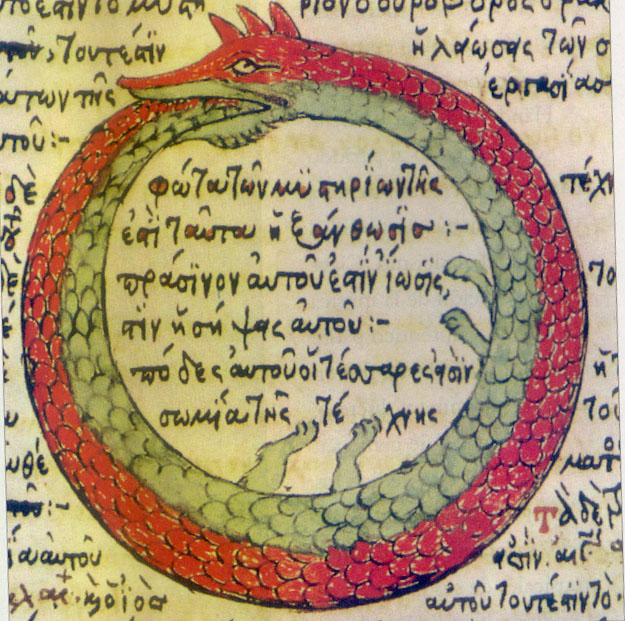

<br><br><br><br><br>

## Calling C functions from Python without a library

In [ ]:
import ctypes

Here is a library that everyone has:

In [ ]:
libc = ctypes.cdll.LoadLibrary("libc.so.6")

And here's a function in the library that we can call. We're passing `None` as the first argument, which Python translates to `nullptr` in this signature:

```c
time_t time(time_t*);
```

According to [the documentation](https://man7.org/linux/man-pages/man2/time.2.html), the argument is for reusing a `time_t` integer, and `nullptr` skips that.

In [ ]:
libc.time(None)

Compare with Python's `time.time`:

In [ ]:
import time

libc.time(None), time.time()

See the [ctypes documentation](https://docs.python.org/3/library/ctypes.html) for more.

<br><br><br><br><br>

## Manipulating Python objects as C structs

In CPython, an object's `id` is its C pointer. This is not a part of the language definition and could change in the future, but it's true right now.

In [ ]:
class SomeType:
    pass

some_object = SomeType()

In [ ]:
id(some_object)

<br><br><br><br><br>

Also in CPython, the first two data members of `struct PyObject` are

```c
struct PyObject {
    Py_size_t ob_refcnt;   // reference count for garbage collection
    PyObject* ob_type;     // the object's type
                           // ...
};
```

Different kinds of objects have different numbers of data members beyond that, but just these will make an interesting demonstration.

In [ ]:
class PyObject(ctypes.Structure):
    pass

PyObject._fields_ = [
    ("ob_refcnt", ctypes.c_int64),
    ("ob_type", ctypes.POINTER(PyObject)),
]

In [ ]:
c_some_object = PyObject.from_address(id(some_object))

In [ ]:
ctypes.cast(c_some_object.ob_type, ctypes.c_void_p).value

In [ ]:
id(SomeType)

<br><br>

Incidentally, what's the type's type?

In [ ]:
c_SomeType = PyObject.from_address(id(SomeType))

In [ ]:
ctypes.cast(c_SomeType.ob_type, ctypes.c_void_p).value

In [ ]:
id(type)

And what's its type?

In [ ]:
c_type = PyObject.from_address(id(type))

In [ ]:
ctypes.cast(c_type.ob_type, ctypes.c_void_p).value

That's because

In [ ]:
type(SomeType) is type

In [ ]:
type(type) is type

In [ ]:
type(type(type)) is type

(`type` is an example of an object that you _cannot_ make, using the Python language itself.)

<br><br>

Python provides a way to see an object's reference count, but since it's a Python function, it also modifies the reference count.

In [ ]:
import sys

In [ ]:
another_object = SomeType()

In [ ]:
sys.getrefcount(another_object)

`sys.getrefcount` will _always_ return at least 2: the object has to have a reference to pass it into this function, and putting it on the argument list of a function (temporarily) increases its reference count.

In [ ]:
lst = []
for _ in range(5):
    lst.append(another_object)
    print(sys.getrefcount(another_object))

In [ ]:
del lst

In [ ]:
sys.getrefcount(another_object)

<br><br>

The reference count that we see through the C interface does not change it.

In [ ]:
c_another_object = PyObject.from_address(id(another_object))

In [ ]:
c_another_object.ob_refcnt

In [ ]:
lst = []
for _ in range(5):
    lst.append(another_object)
    print(c_another_object.ob_refcnt)

In [ ]:
del lst

In [ ]:
c_another_object.ob_refcnt

<br><br><br><br><br>

## Changing immutable data

Some Python objects, like `str` and `bytes` strings, are immutable. They can't be changed by any Python functions... unless you count ctypes functions.

In [ ]:
some_string = "This is a string. You can't change me. Ha!"

In [ ]:
some_string[22:27] = " CAN "

<br><br>

In [ ]:
import numpy as np

In [ ]:
ptr = ctypes.cast(id(some_string), ctypes.POINTER(ctypes.c_uint8))

In [ ]:
array = np.ctypeslib.as_array(ptr, (sys.getsizeof(some_string),))

In [ ]:
array

In [ ]:
array.tobytes()

Do you see the string data? It's buried pretty deep, under various `PyObject*` data members.

In [ ]:
array[70:75] = list(map(ord, " CAN "))

In [ ]:
array.tobytes()

In [ ]:
some_string

<br><br>

Since Python optimizations assume that strings don't change, it would be a bad idea to do this in code that you care about.

Actually, everything in this notebook is a bad idea.

<br><br><br><br><br>

## Changing Python built-in types

Python would be more FUNctional if the `list` type had `map` and `reduce` methods.

In [ ]:
list.map = lambda self, function: [function(x) for x in self]

You can do that for user-defined types, but not for the built-in `list` type.

<br><br>

Unless you modify Python's C code while it's running.  `:)`

In [ ]:
class SlotsPointer(PyObject):
    _fields_ = [("dict", ctypes.POINTER(PyObject))]

def proxy_builtin(cls):
    name = cls.__name__
    slots = getattr(cls, "__dict__", name)

    ptr = SlotsPointer.from_address(id(slots))
    namespace = {}

    ctypes.pythonapi.PyDict_SetItem(
        ctypes.py_object(namespace),
        ctypes.py_object(name),
        ptr.dict,
    )

    return namespace[name]

In [ ]:
# don't run this cell twice... it will cause Python to segfault

def list_map(self, function):
    return [function(x) for x in self]

proxy_builtin(list)["map"] = list_map

In [ ]:
[1, 2, 3, 4, 5].map(lambda x: x**2)

In [ ]:
# don't run this cell twice... it will cause Python to segfault

def list_reduce(self, function, initial=None):
    if initial is None:
        result = self[0]
        for x in self[1:]:
            result = function(result, x)
        return result
    else:
        result = initial
        for x in self:
            result = function(result, x)
        return result

proxy_builtin(list)["reduce"] = list_reduce

In [ ]:
[1, 2, 3, 4, 5].reduce(lambda x, y: x + y)

<br><br><br><br><br>

## Python bytecodes

Unlike `baby-python`, Python compiles source code to bytecode instructions (integers) for a virtual machine, instead of walking an AST tree at runtime.

You might have seen the `.pyc` files that it generates: these are cached bytecodes, so that Python doesn't have to parse source code twice.

In [ ]:
def f(x):
    return ((x + 123) * x - 321) / x

In [ ]:
f.__code__.co_code

In [ ]:
np.frombuffer(f.__code__.co_code, np.uint8).reshape(-1, 2)

Python's dis module interprets it as "Python assembly code."

In [ ]:
import dis

In [ ]:
print(dis.code_info(f))

In [ ]:
dis.dis(f)

The equivalent bytecode for physical machines is

<table>
    <tr style="background: white;"><td style="font-weight: bold;">Intel-compatible (x86)</td><td></td><td style="font-weight: bold;">Apple Silicon (ARM)</td></tr>
    <tr style="background: white;"><td><pre>machine code       assembly code
================================================
55                 push   rbp
48 89 e5           mov    rbp, rsp
89 7d fc           mov    DWORD PTR [rbp-4], edi
8b 45 fc           mov    eax, DWORD PTR [rbp-4]
83 c0 7b           add    eax, 123
0f af 45 fc        imul   eax, DWORD PTR [rbp-4]
2d 41 01 00 00     sub    eax, 321
99                 cltd
f7 7d fc           idivl  DWORD PTR [rbp-4]
5d                 pop    rbp
c3                 ret</pre></td><td><pre>     </pre></td><td><pre>machine code    assembly code
====================================
ff 43 00 d1     sub    sp, sp, #16
e0 0f 00 b9     str    w0, [sp, #12]
e8 0f 40 b9     ldr    w8, [sp, #12]
08 ed 01 11     add    w8, w8, #123
e9 0f 40 b9     ldr    w9, [sp, #12]
08 7d 09 1b     mul    w8, w8, w9
08 05 05 71     subs   w8, w8, #321
e9 0f 40 b9     ldr    w9, [sp, #12]
00 0d c9 1a     sdiv   w0, w8, w9
ff 43 00 91     add    sp, sp, #16
c0 03 5f d6     ret</pre></td></tr>
</table>

Some differences: x86 has a variable number of bytes per instruction, but ARM is always 4-byte and Python bytecodes are 2-byte (since Python 3.6).

Also, constants like 123 (`7b`) and 321 (`41 01 00 00`) are embedded in the x86, rather than as references to a look-up table, as in Python. Do you see them?

In [ ]:
%%writefile example.c

int f(int x) {
  return ((x + 123) * x - 321) / x;
}

In [ ]:
!cc -O0 -c example.c

In [ ]:
!objdump -d example.o

or use https://godbolt.org/.

<br><br><br><br><br>

## How fast is the Python virtual machine?

A single Python bytecode might call a compiled extension that processes terabytes of data for hours, so the execution of each bytecode is highly variable.

However, I'd like to know what overhead merely walking through the Python instruction sequence adds to a computation. At what order of magnitude in time should we worry about the difference between Python code and compiled code?

Adding integers is about the fastest _physical_ instruction there is, so let's see how much more time it takes Python to add integers than C.

In [ ]:
def f():
    x = 0
    for _ in range(10_000_000):
        x = 10 + x - 10 + x + 10 + x - 10 + x + 10 + x - 10

There are 25 Python bytecode instructions inside the `for` loop, and they get repeated 10 million times.

(The reason that I put many additions/subtractions in the loop is so that the time is dominated by those instructions and not the ones that manage the loop logic.)

(The reason I alternate between adding constants and adding variables is because the Python compiler is smart enough to combine mathematical operations on constants into a constant.)

(The reason that the result is arranged to sum to zero is so that we don't spend time in Python's arbitrary precision arithmetic module.)

In [ ]:
dis.dis(f)

In [ ]:
import time

In [ ]:
start = time.time()

f()

(time.time() - start) * 1e9 / (25*10000000)   # nanoseconds per instruction

<br><br><br><br><br>

To do a similar measurement with compiled code, we need to run the loop 1 billion times.

In [ ]:
%%writefile example.c

void run() {
    int x = 0;
    for (int i = 0;  i < 1000000000;  i++) {
        x = 10 + x - 10 + x + 10 + x - 10 + x + 10 + x - 10;
    }
}

In [ ]:
!cc -O0 -c example.c

In [ ]:
!objdump -d example.o

x86 code has 18 instructions in the loop; ARM has 23.

All of this is very rough: physical processors also _pipeline_ instructions, so the throughput—the number of operations per second—isn't simply related to the latency—the time for one operation.

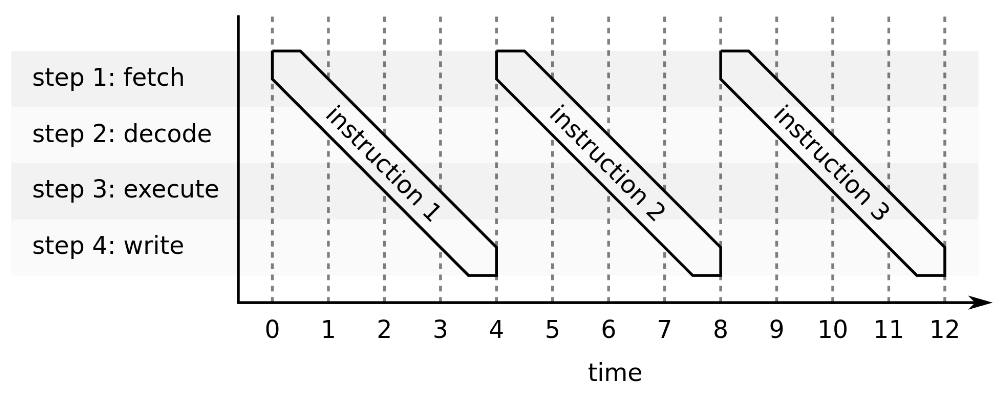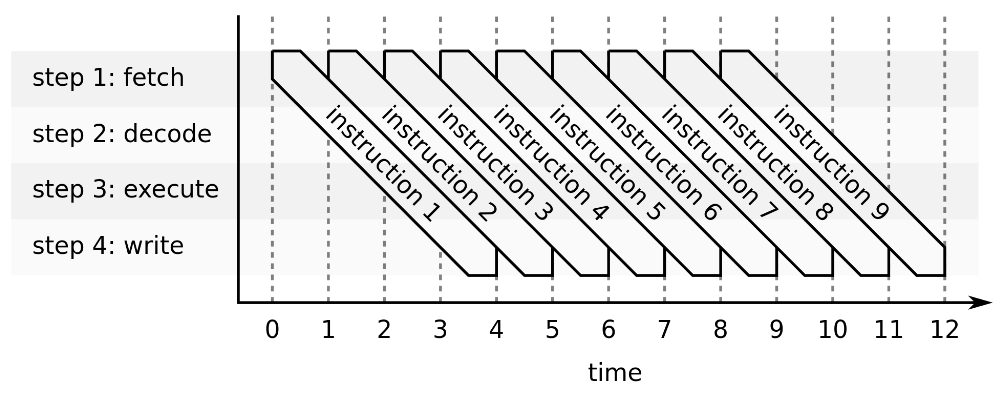

In [ ]:
!cc -O0 -shared example.c -o libexample.so

In [ ]:
libexample = ctypes.cdll.LoadLibrary("./libexample.so")

In [ ]:
start = time.time()

libexample.run()

(time.time() - start) * 1e9 / (20*1000000000)   # nanoseconds per instruction

Python spends about 40× as much time stepping through its bytecode instructions than actually computing sums.

<br><br><br><br><br>

To do this in baby-python, we need an input dataset of size 1 million to run a reduction over.

In [ ]:
np.zeros(1_000_000).astype(np.int32).tofile("data.int32")

```
./baby-python data=data.int32
                     num = -123        add(x, x)   get(lst, i)   map(f, lst)
               oo    lst = [1, 2, 3]   mul(x, x)   len(lst)      reduce(f, lst)
. . . __/\_/\_/`'    f = def(x) single-expr   f = def(x, y) { ... ; last-expr }

>> f = def(x, ignore) add(10, add(x, add(-10, add(x, add(10, add(x, add(-10, add(x, add(10, add(x, -10))))))))))
<user-defined function>
(1.27e-06 seconds)
>> reduce(f, data, 0)
0
(1.98543 seconds)
>>
```

In [ ]:
2 * 1e9 / 1_000_000   # nanoseconds per instruction

baby-python spends whole _microseconds_ stepping through its (dynamically typed) AST of instructions.